In [1]:
%%capture
!pip install uproot

In [2]:
import os

# Define your workspace directory
workspace_dir = '/content/anomaly-detection-in-HEP/code'

# Create the directory if it doesn't exist
if not os.path.exists(workspace_dir):
    os.makedirs(workspace_dir)

# Change the current working directory to your workspace directory
os.chdir(workspace_dir)

# Verify the current working directory
print('Current working directory:', os.getcwd())


Current working directory: /content/anomaly-detection-in-HEP/code


In [3]:
# from preprocessing.dataset import dataset
from torch.utils.data import DataLoader
# from training.trainer import trainer
# from models.vae import VAE, AE
# from models.ode import ode
# from evaluation.evaluator import evaluator
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
import torch
import os
import sys
from copy import copy
from torchsummary import summary
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Background data

In [14]:
from google.cloud import storage
from io import BytesIO
import uproot

def get_data_from_root(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_dir)
        file_contents = BytesIO(blob.download_as_string())
        tree = uproot.open(file_contents)
        data = tree['Delphes']
        return data

data_file = 'QCD_LLP_samples/root-files/qcd_100k.root'
data = get_data_from_root(data_file)
features = ['Track.PT', 'Track.Eta', 'Track.Phi', 'Track.D0', 'Track.DZ']

In [15]:
from itertools import chain
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

data_train = []
data_test = []
data_test2 = []
for i in range(5):
  d = data['Track'][features[i]].array().tolist()
  d = list(chain.from_iterable(d))
  data_train.append(d[:100_000])
  data_test2.append(d[100_000:110_000])
  data_test.append(d[-10_000:])
data_bkg_train = torch.tensor(data_train).T
data_bkg_test = torch.tensor(data_test).T
data_bkg_test2 = torch.tensor(data_test).T
del data, data_train, data_test, data_test2

In [16]:
means = data_bkg_train.mean(dim=0)
stds = data_bkg_train.std(dim=0)

data_bkg_train = (data_bkg_train - means) / stds
data_bkg_test =(data_bkg_test - means) / stds
data_bkg_test2 = (data_bkg_test2 - means)/stds
print("Train shape:", data_bkg_train.shape)
print("Valid shape:", data_bkg_test.shape)

Train shape: torch.Size([100000, 5])
Valid shape: torch.Size([10000, 5])


## Signal data

In [17]:
import h5py
def get_data_from_h5(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_dir)
        file_contents = BytesIO(blob.download_as_string())
        with h5py.File(file_contents, 'r') as f:
            dataset = f['Track']
            data = dataset[:10_000]
            d1 = dataset[:10_000]
            d2 = dataset[10_000:10_500]
        return d1, d2

In [18]:
sig1_train, sig1_test = get_data_from_h5('QCD_LLP_samples/h5-files/500GeV_n3_events_100k_1mm_pileup.h5')
sig2_train, sig2_test = get_data_from_h5('QCD_LLP_samples/h5-files/100GeV_n3_events_100k_1mm_pileup.h5')

In [19]:
data_sig_train = np.concatenate((sig1_train,sig2_train))
data_sig_test = np.concatenate((sig1_test,sig2_test))

In [20]:
data_sig_train = torch.tensor([list(data_sig_train[i]) for i in range(data_sig_train.shape[0])])
data_sig_test = torch.tensor([list(data_sig_test[i]) for i in range(data_sig_test.shape[0])])

In [21]:
data_sig_train = (data_sig_train - means) / stds
data_sig_test =(data_sig_test - means) / stds

print("Train shape:", data_sig_train.shape)
print("Test shape:", data_sig_test.shape)

Train shape: torch.Size([20000, 5])
Test shape: torch.Size([1000, 5])


# Train VAE model

In [7]:
BATCH_SIZE = 5058
DROPOUT_RATE = 0.01
beta = 0.0
lr = 1e-2
latent_dim = 2
num_epochs = 70

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(in_features=input_dim, out_features=512)
        self.fc21 = nn.Linear(in_features=512, out_features=latent_dim)
        self.fc22 = nn.Linear(in_features=512, out_features=latent_dim)
        self.fc3 = nn.Linear(in_features=latent_dim, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=input_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def encode(self, x):
        h1 = self.dropout(self.relu(self.fc1(x)))
        return self.dropout(self.fc21(h1)), self.dropout(self.fc22(h1))

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.tanh(self.dropout(self.fc4(h3)))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = torch.mean(torch.pow(recon_x - x, 2)) #/ BATCH_SIZE
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) #/ BATCH_SIZE
        return (1-beta)*recon_loss + beta*kl_loss


class AE(nn.Module):
    def __init__(self, input_dim, latent_dim, dropout_rate=0.1):
        super(AE, self).__init__()

        self.fc1 = nn.Linear(in_features=input_dim, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=latent_dim)
        self.fc3 = nn.Linear(in_features=latent_dim, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=input_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h1 = self.dropout(self.relu(self.fc1(x)))
        return self.dropout(self.fc2(h1))

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.tanh(self.dropout(self.fc4(h3)))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss_function(self, recon_x, x):
        recon_loss = torch.mean(torch.pow(recon_x - x, 2))  # Mean Squared Error Loss
        return recon_loss

In [8]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vae = AE(input_dim=5, latent_dim=latent_dim)
model_vae = model_vae.to(device)
summary(model_vae, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           3,072
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                    [-1, 2]           1,026
           Dropout-5                    [-1, 2]               0
            Linear-6                  [-1, 512]           1,536
              ReLU-7                  [-1, 512]               0
            Linear-8                    [-1, 5]           2,565
           Dropout-9                    [-1, 5]               0
             Tanh-10                    [-1, 5]               0
Total params: 8,199
Trainable params: 8,199
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total

In [10]:
from datetime import datetime

train_loader = DataLoader(data_bkg_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valid_loader = DataLoader(data_bkg_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)
optimizer=optim.Adam(model_vae.parameters(), lr=lr)

train_losses = []
valid_losses = []
for epoch in range(num_epochs):
  starting_time = datetime.now()
  epoch_train_loss = 0.0
  epoch_valid_loss = 0.0

  # Training
  model_vae.train()
  for inputs in train_loader:
    optimizer.zero_grad()
    inputs = inputs.to(device)
    inputs_recon = model_vae(inputs)
    inputs_recon = inputs_recon.to(device)
    train_loss = model_vae.loss_function(inputs, inputs_recon)
    # inputs_recon, mu, logvar = model_vae(inputs)
    # inputs_recon, mu, logvar = inputs_recon.to(device), mu.to(device), logvar.to(device)
    # train_loss = model_vae.loss_function(inputs, inputs_recon, mu, logvar)
    train_loss.backward()
    optimizer.step()
    epoch_train_loss += train_loss.item()

  # Validation
  # model_vae.eval()
  # with torch.no_grad():
  for data in valid_loader:
        x = data
        inputs = x.to(device)
        inputs_recon = model_vae(inputs)
        inputs_recon = inputs_recon.to(device)
        valid_loss = model_vae.loss_function(inputs, inputs_recon)
        # x_recon, mu, logvar = model_vae(inputs)
        # valid_loss = model_vae.loss_function(inputs, x_recon, mu, logvar)
        epoch_valid_loss += valid_loss.item()

  epoch_train_loss /= len(train_loader)
  epoch_valid_loss /= len(valid_loader)

  train_losses.append(epoch_train_loss)
  valid_losses.append(epoch_valid_loss)

  time_elapsed = datetime.now() - starting_time
  print('Epoch: {}, Train len batch: {}, Train loss: {:.4f}, Valid loss: {:.4f}, Time elapsed (hh:mm:ss.ms) {}'.format(
                    epoch,len(train_loader) ,epoch_train_loss, epoch_valid_loss, time_elapsed
  ))


Epoch: 0, Train len batch: 20, Train loss: 0.8388, Valid loss: 0.6754, Time elapsed (hh:mm:ss.ms) 0:00:04.472315
Epoch: 1, Train len batch: 20, Train loss: 0.6599, Valid loss: 0.5906, Time elapsed (hh:mm:ss.ms) 0:00:04.535093
Epoch: 2, Train len batch: 20, Train loss: 0.6252, Valid loss: 0.5756, Time elapsed (hh:mm:ss.ms) 0:00:04.480972
Epoch: 3, Train len batch: 20, Train loss: 0.6099, Valid loss: 0.5631, Time elapsed (hh:mm:ss.ms) 0:00:04.498242
Epoch: 4, Train len batch: 20, Train loss: 0.6091, Valid loss: 0.5678, Time elapsed (hh:mm:ss.ms) 0:00:04.443836
Epoch: 5, Train len batch: 20, Train loss: 0.6026, Valid loss: 0.5543, Time elapsed (hh:mm:ss.ms) 0:00:04.496172
Epoch: 6, Train len batch: 20, Train loss: 0.5968, Valid loss: 0.5542, Time elapsed (hh:mm:ss.ms) 0:00:04.464682
Epoch: 7, Train len batch: 20, Train loss: 0.5942, Valid loss: 0.5536, Time elapsed (hh:mm:ss.ms) 0:00:04.480006
Epoch: 8, Train len batch: 20, Train loss: 0.5943, Valid loss: 0.5561, Time elapsed (hh:mm:ss.ms

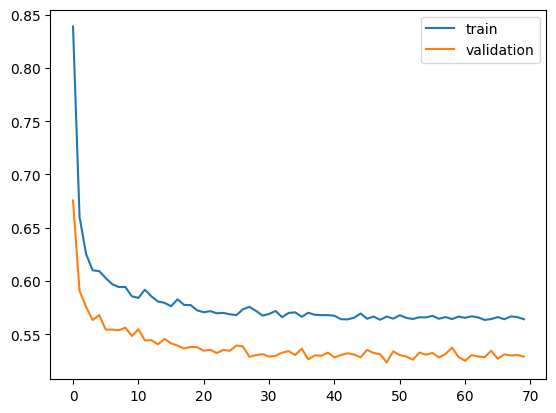

In [12]:
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

# Test the model

In [30]:
bkg_mse = []
for x in data_bkg_test2:
  x = x.to(device)
  output = model_vae(x)
  mse = model_vae.loss_function(x, output)
  bkg_mse.append(mse.item())

In [29]:
sig_mse = []
for x in data_sig_train:
  x = x.to(device)
  output = model_vae(x)
  mse = model_vae.loss_function(x, output)
  sig_mse.append(mse.item())

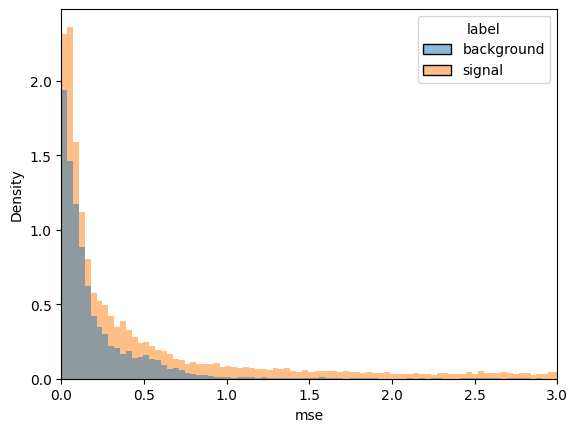

In [52]:
import seaborn as sns
import pandas as pd

hist_data = pd.DataFrame({'mse': bkg_mse+sig_mse, 'label': ['background']*len(bkg_mse) + ['signal']*len(sig_mse)})
sns.histplot(data=hist_data, x='mse', hue='label', stat='density')
plt.xlim((0,3))
plt.show()